# CMP

## Init

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from movement_primitives.data import generate_1d_trajectory_distribution
from movement_primitives.promp import ProMP

## Data

In [2]:
n_demos = 30
n_steps = 103
T1, Y1 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(0))
_, Y2 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(1))
Y2 = Y2 + 1
_, Y3 = generate_1d_trajectory_distribution(n_demos, n_steps, initial_offset_range=3.0, final_offset_range=1,
        noise_per_step_range=20.0, random_state=np.random.RandomState(2))
Y3 = Y3 - 1

In [3]:
T2 = T1 + T1[-1]
T3 = T1 + 2*T1[-1]

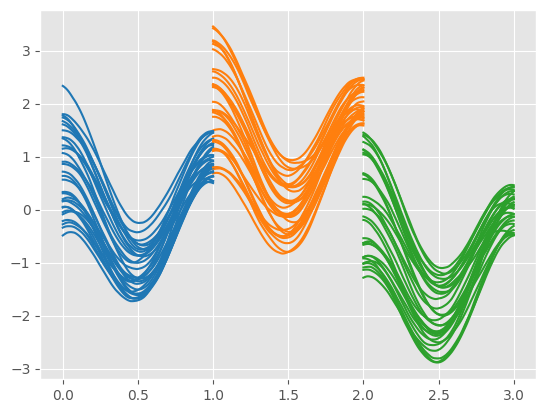

In [4]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()
    for demo in range(n_demos):
        ax.plot(T1, Y1[demo, :, 0], c=cmap[0])
        ax.plot(T2, Y2[demo, :, 0], c=cmap[1])
        ax.plot(T3, Y3[demo, :, 0], c=cmap[2])
    plt.show()

In [5]:
z = np.linspace(start=0, stop=1, num=n_steps)
z.shape

(103,)

## Learn the ProMPs

In [6]:
promp1 = ProMP(n_dims=1, n_weights_per_dim=10)
promp1.imitate([z] * n_demos, Y1)
Y_mean1 = promp1.mean_trajectory(z)
Y_conf1 = 1.96 * np.sqrt(promp1.var_trajectory(z))

promp2 = ProMP(n_dims=1, n_weights_per_dim=10)
promp2.imitate([z] * n_demos, Y2)
Y_mean2 = promp2.mean_trajectory(z)
Y_conf2 = 1.96 * np.sqrt(promp2.var_trajectory(z))

promp3 = ProMP(n_dims=1, n_weights_per_dim=10)
promp3.imitate([z] * n_demos, Y3)
Y_mean3 = promp3.mean_trajectory(z)
Y_conf3 = 1.96 * np.sqrt(promp3.var_trajectory(z))

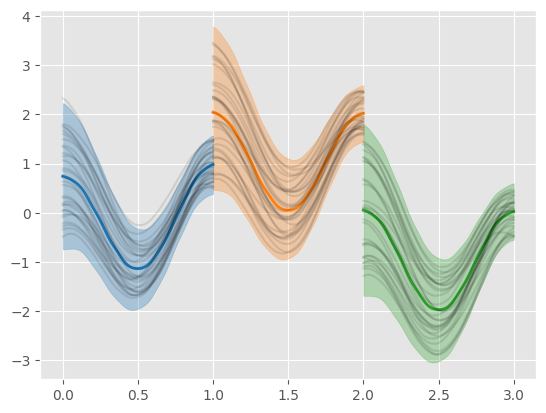

In [7]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()

    ax.fill_between(T1, (Y_mean1 - Y_conf1).ravel(), (Y_mean1 + Y_conf1).ravel(), color=cmap[0], alpha=0.3)
    ax.plot(T1, Y_mean1, c=cmap[0], lw=2)
    ax.plot(T1, Y1[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T2, (Y_mean2 - Y_conf2).ravel(), (Y_mean2 + Y_conf3).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T2, Y_mean2, c=cmap[1], lw=2)
    ax.plot(T2, Y2[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T3, (Y_mean3 - Y_conf3).ravel(), (Y_mean3 + Y_conf3).ravel(), color=cmap[2], alpha=0.3)
    ax.plot(T3, Y_mean3, c=cmap[2], lw=2)
    ax.plot(T3, Y3[:, :, 0].T, c="k", alpha=0.1)
    plt.show()

## Via-points

In [8]:
y_A = np.mean([Y_mean1[-1], Y_mean2[0]])
y_B = np.mean([Y_mean2[-1], Y_mean3[0]])
y_cond = np.array([y_A, y_B])
y_cond

array([1.51391313, 1.03896116])

In [9]:
x_cond = np.array([T1[-1], T2[-1]])
x_cond

array([1., 2.])

In [10]:
y_conditional_cov = np.array([0.025])

In [11]:
# k = 3
# z_kA = 1/k
# z_kB = 2/k
# z_k = np.array([z_kA, z_kB])

In [12]:
# y_cov = np.eye(2) * y_conditional_cov
# y_cov, np.linalg.det(y_cov)

In [13]:
cpromp1 = promp1.condition_position(np.array([y_A]), y_cov=y_conditional_cov, t=1.0, t_max=1.0)
Y_cmean1 = cpromp1.mean_trajectory(z)
Y_cconf1 = 1.96 * np.sqrt(cpromp1.var_trajectory(z))

In [14]:
cpromp2 = promp2.condition_position(np.array([y_A]), y_cov=y_conditional_cov, t=0.0, t_max=1.0)
Y_cmean2 = cpromp2.mean_trajectory(z)
Y_cconf2 = 1.96 * np.sqrt(cpromp2.var_trajectory(z))

In [17]:
cpromp25 = cpromp2.condition_position(np.array([y_B]), y_cov=y_conditional_cov, t=1.0, t_max=1.0)
Y_cmean25 = cpromp25.mean_trajectory(z)
Y_cconf25 = 1.96 * np.sqrt(cpromp25.var_trajectory(z))

In [18]:
cpromp3 = promp3.condition_position(np.array([y_B]), y_cov=y_conditional_cov, t=0.0, t_max=1.0)
Y_cmean3 = cpromp3.mean_trajectory(z)
Y_cconf3 = 1.96 * np.sqrt(cpromp3.var_trajectory(z))

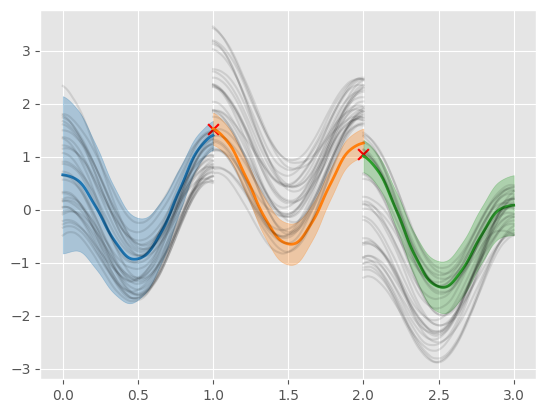

In [19]:
with mpl.style.context("ggplot"):
    cmap = mpl.colormaps["tab10"].colors
    fig, ax = plt.subplots()

    ax.fill_between(T1, (Y_cmean1 - Y_cconf1).ravel(), (Y_cmean1 + Y_cconf1).ravel(), color=cmap[0], alpha=0.3)
    ax.plot(T1, Y_cmean1, c=cmap[0], lw=2)
    ax.plot(T1, Y1[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T2, (Y_cmean25 - Y_cconf25).ravel(), (Y_cmean25 + Y_cconf25).ravel(), color=cmap[1], alpha=0.3)
    ax.plot(T2, Y_cmean25, c=cmap[1], lw=2)
    ax.plot(T2, Y2[:, :, 0].T, c="k", alpha=0.1)

    ax.fill_between(T3, (Y_cmean3 - Y_cconf3).ravel(), (Y_cmean3 + Y_cconf3).ravel(), color=cmap[2], alpha=0.3)
    ax.plot(T3, Y_cmean3, c=cmap[2], lw=2)
    ax.plot(T3, Y3[:, :, 0].T, c="k", alpha=0.1)

    ax.scatter(x_cond, y_cond, marker="x", c="r", s=60)
    plt.show()